# Supervised machine learning: Introduction and regularization 
## Binary classification with text data

# Imports

In [2]:
## load packages 
import pandas as pd
import re
import numpy as np
import plotnine
from plotnine import *
import pickle

## nltk imports
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

## sklearn imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## random
import random

pd.set_option('display.max_colwidth', None)

In [4]:
## function to process text
def processtext(one_str, stop_list):
    
    ## remove stopwords
    no_stop = [tok for tok in wordpunct_tokenize(one_str)
              if tok not in stop_list]
    
    
    processed_string = " ".join([porter.stem(i.lower()) 
                        for i in no_stop if 
                        i.lower().isalpha() and len(i) >=3])
    return(processed_string)

## function to create dtm
def create_dtm(list_of_strings, metadata):
    vectorizer = CountVectorizer(lowercase = True)
    dtm_sparse = vectorizer.fit_transform(list_of_strings)
    dtm_dense_named = pd.DataFrame(dtm_sparse.todense(), columns=vectorizer.get_feature_names_out())
    dtm_dense_named_withid = pd.concat([metadata.reset_index(), dtm_dense_named], axis = 1)
    return(dtm_dense_named_withid)

# Load data

Load labeled yelp data in `public_data` and run below code

**Note**: make sure to change your path if you need to; if you're having trouble loading the `pkl`, try running on jupyter hub since it may be a python versioning issue

In [6]:
# If you have trouble loading these data (kernel dies due to memory issues), try sampling down to 5000 or 1000 rows
yelp = pd.read_pickle("../public_data/yelp_forML.pkl") #.sample(n=1000)

In [14]:
yelp

,metadata_rowid,metadata_label,raw_text,process_text
0,0,0,"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff. It seems that his staff simply never answers the phone. It usually takes 2 hours of repeated calling to get an answer. Who has time for that or wants to deal with it? I have run into this problem with many other doctors and I just don't get it. You have office workers, you have patients with medical needs, why isn't anyone answering the phone? It's incomprehensible and not work the aggravation. It's with regret that I feel that I have to give Dr. Goldberg 2 stars.",unfortun frustrat goldberg patient repeat experi mani doctor nyc good doctor terribl staff seem staff simpli never answer phone usual take hour repeat call get answer who time want deal run problem mani doctor get you offic worker patient medic need anyon answer phone incomprehens work aggrav regret feel give goldberg star
1,1,1,"Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life.",been go goldberg year think one patient start mhmg great year realli big pictur former gyn markoff found fibroid explor option patient understand judg ask right question veri thorough want kept loop everi aspect medic health life
2,2,0,"I don't know what Dr. Goldberg was like before moving to Arizona, but let me tell you, STAY AWAY from this doctor and this office. I was going to Dr. Johnson before he left and Goldberg took over when Johnson left. He is not a caring doctor. He is only interested in the co-pay and having you come in for medication refills every month. He will not give refills and could less about patients's financial situations. Trying to get your 90 days mail away pharmacy prescriptions through this guy is a joke. And to make matters even worse, his office staff is incompetent. 90% of the time when you call the office, they'll put you through to a voice mail, that NO ONE ever answers or returns your call. Both my adult children and husband have decided to leave this practice after experiencing such frustration. The entire office has an attitude like they are doing you a favor. Give me a break! Stay away from this doc and the practice. You deserve better and they will not be there when you really need them. I have never felt compelled to write a bad review about anyone until I met this pathetic excuse for a doctor who is all about the money.",know goldberg like move arizona let tell stay away doctor offic go johnson left goldberg took johnson left care doctor interest pay come medic refil everi month give refil could less patient financi situat tri get day mail away pharmaci prescript guy joke and make matter even wors offic staff incompet time call offic put voic mail one ever answer return call both adult children husband decid leav practic experienc frustrat the entir offic attitud like favor give break stay away doc practic you deserv better realli need never felt compel write bad review anyon met pathet excus doctor money
3,3,0,"I'm writing this review to give you a heads up before you see this Doctor. The office staff and administration are very unprofessional. I left a message with multiple people regarding my bill, and no one ever called me back. I had to hound them to get an answer about my bill. \n\nSecond, and most important, make sure your insurance is going to cover Dr. Goldberg's visits and blood work. He recommended to me that I get a physical, and he knew I was a student because I told him. I got t

In [8]:
## preprocess data to create dtm
porter = PorterStemmer()
list_stopwords = stopwords.words("english")

yelp['process_text'] = [processtext(one_review, stop_list = list_stopwords) 
                        for one_review in yelp['raw_text']]

yelp_dtm = create_dtm(yelp['process_text'], yelp[['metadata_label', 'metadata_rowid',
                                                 'process_text', 'raw_text']])

In [24]:
## when you have something that takes time, run it on a subset first so you know its actually doing what you want

%%time
[processtext(one_review, stop_list = list_stopwords) 
                        for one_review in yelp['raw_text'].sample(n=100)]


CPU times: user 82 ms, sys: 2.82 ms, total: 84.8 ms
Wall time: 84.4 ms


['ryan pet suppli wonder staff repair shop the best custom servic town',
 'thi first time visit charlott three month stay surpris book may read charlott mecklenburg librari system true enough someon lo angel like new york boston would complet delight rang subject matter find someth upon entri departur enjoy read quot pillar happi hunt word caution bring sturdi bag home carri book the librari design bag give flimsi one groceri store nthi locat close sunday monday summer',
 'husband visit mph last night read great review yelp thi place disappoint nthe decor insid mph color welcom noth special nice sat immedi drink order taken the review chip salsa exagger the chip thicker almost softer delici warm salti the red salsa nice rich spici flavor green salsa green salsa the green salsa avocado cilantro base wonder fresh almost tangi flavor compliment well creami avocado bring dish when drink arriv husband delight ici mexican coca cola our waiter also brought fish cevich tostada though surpris t

In [16]:
yelp_dtm

,index,metadata_label,metadata_rowid,process_text,raw_text,aaa,aaaaaa,aaaaaaaaaaaaaaand,aaaaaaaaaaaaahhhhhhhhhhh,aaaaand,...,zoom,zorba,zucchini,zuch,zuchinni,zum,zuma,zumba,zuppa,zwei
0,0,0,0,unfortun frustrat goldberg patient repeat experi mani doctor nyc good doctor terribl staff seem staff simpli never answer phone usual take hour repeat call get answer who time want deal run problem mani doctor get you offic worker patient medic need anyon answer phone incomprehens work aggrav regret feel give goldberg star,"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff. It seems that his staff simply never answers the phone. It usually takes 2 hours of repeated calling to get an answer. Who has time for that or wants to deal with it? I have run into this problem with many other doctors and I just don't get it. You have office workers, you have patients with medical needs, why isn't anyone answering the phone? It's incomprehensible and not work the aggravation. It's with regret that I feel that I have to give Dr. Goldberg 2 stars.",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,been go goldberg year think one patient start mhmg great year realli big pictur former gyn markoff found fibroid explor option patient understand judg ask right question veri thorough want kept loop everi aspect medic health life,"Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life.",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,2,know goldberg like move arizona let tell stay away doctor offic go johnson left goldberg took johnson left care doctor interest pay come medic refil everi month give refil could less patient financi situat tri get day mail away pharmaci prescript guy joke and make matter even wors offic staff incompet time call offic put voic mail one ever answer return call both adult children husband decid leav practic experienc frustrat the entir offic attitud like favor give break stay away doc practic you deserv better realli need never felt compel write bad review anyon met pathet excus doctor money,"I don't know what Dr. Goldberg was like before moving to Arizona, but let me tell you, STAY AWAY from this doctor and this office. I was going to Dr. Johnson before he left and Goldberg took over when Johnson left. He is not a caring doctor. He is only interested in the co-pay and having you come in for medication refills every month. He will not give refills and could less about patients's financial situations. Trying to get your 90 days mail away pharmacy prescriptions through this guy is a joke. And to make matters even worse, his office staff is incompetent. 90% of the time when you call the office, they'll put you through to a voice mail, that NO ONE ever answers or returns your call. Both my adult children and husband have decided to leave this practice after experiencing such frustration. The entire office has an attitude like they are doing you a favor. Give me a break! Stay away from this doc and the practice. You deserve better and they will not be there when you really need them. I have never felt compelled to write a bad review about anyone until I met this pathetic excuse for a doctor who is all about the money.",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,3,write review give head see doctor the offic staff administr unprofession left messag multipl peopl regard bill one ever call back hound get answer bill nsecond import make sure insur go cover goldberg visit blood work recommend get physic knew stud

# 1. Split into features, labels, and split into training/hold out

## 1.1 Split into X (features or id metadata) and y (labels)

In [10]:
X = yelp_dtm[[col for col in yelp_dtm.columns if col not in ['metadata_label',
                                                            'index']]].copy()
y = yelp_dtm[['metadata_label']]

In [26]:
## X and y should have same number of columns
## y is just taking out the metadatalabel and X is having everything else (so y is the binary classification result)

,metadata_rowid,process_text,raw_text,aaa,aaaaaa,aaaaaaaaaaaaaaand,aaaaaaaaaaaaahhhhhhhhhhh,aaaaand,aaaaannnd,aaaand,...,zoom,zorba,zucchini,zuch,zuchinni,zum,zuma,zumba,zuppa,zwei
0,0,unfortun frustrat goldberg patient repeat experi mani doctor nyc good doctor terribl staff seem staff simpli never answer phone usual take hour repeat call get answer who time want deal run problem mani doctor get you offic worker patient medic need anyon answer phone incomprehens work aggrav regret feel give goldberg star,"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff. It seems that his staff simply never answers the phone. It usually takes 2 hours of repeated calling to get an answer. Who has time for that or wants to deal with it? I have run into this problem with many other doctors and I just don't get it. You have office workers, you have patients with medical needs, why isn't anyone answering the phone? It's incomprehensible and not work the aggravation. It's with regret that I feel that I have to give Dr. Goldberg 2 stars.",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,been go goldberg year think one patient start mhmg great year realli big pictur former gyn markoff found fibroid explor option patient understand judg ask right question veri thorough want kept loop everi aspect medic health life,"Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life.",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,know goldberg like move arizona let tell stay away doctor offic go johnson left goldberg took johnson left care doctor interest pay come medic refil everi month give refil could less patient financi situat tri get day mail away pharmaci prescript guy joke and make matter even wors offic staff incompet time call offic put voic mail one ever answer return call both adult children husband decid leav practic experienc frustrat the entir offic attitud like favor give break stay away doc practic you deserv better realli need never felt compel write bad review anyon met pathet excus doctor money,"I don't know what Dr. Goldberg was like before moving to Arizona, but let me tell you, STAY AWAY from this doctor and this office. I was going to Dr. Johnson before he left and Goldberg took over when Johnson left. He is not a caring doctor. He is only interested in the co-pay and having you come in for medication refills every month. He will not give refills and could less about patients's financial situations. Trying to get your 90 days mail away pharmacy prescriptions through this guy is a joke. And to make matters even worse, his office staff is incompetent. 90% of the time when you call the office, they'll put you through to a voice mail, that NO ONE ever answers or returns your call. Both my adult children and husband have decided to leave this practice after experiencing such frustration. The entire office has an attitude like they are doing you a favor. Give me a break! Stay away from this doc and the practice. You deserve better and they will not be there when you really need them. I have never felt compelled to write a bad review about anyone until I met this pathetic excuse for a doctor who is all about the money.",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,write review give head see doctor the offic staff administr unprofession left messag multipl peopl regard bill one ever call back hound get answer bill nsecond import make sure insur go cover goldberg visit blood work recommend get physic knew student told

In [28]:
## checking dimensionality
X.shape
y.shape

assert X.shape[0] == y.shape[0]
assert y.shape[1] == 1


(15000, 23439)

(15000, 1)

## 1.2 using automatic function to create train-test split

In [30]:
### using built-in function  
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.2,
                                                   random_state = 221)

In [ ]:
# This is a great function and use it as much as you can.


## 1.3 using more manual approach to create train-test split

In [32]:
### more manually: useful when we want more control
### over the ids (eg clustering or time ordering)
### or if we want to go back to matrix before preprocessing
nrows_train = round(X.shape[0]*0.8)
nrows_test = X.shape[0] - nrows_train
random.seed(221)
train_ids = random.sample(list(set(X['metadata_rowid'])), nrows_train)

def my_split(X, y, 
             train_ids, 
             id_col):
    
    ## get test ids
    test_ids = set(X[id_col]).difference(train_ids)
    
    ## split
    X_train_man = X[X[id_col].isin(train_ids)].copy()
    X_test_man = X[X[id_col].isin(test_ids)].copy()
    y_train_man = y[y.index.isin(train_ids)].iloc[:, 0].to_numpy()
    y_test_man = y[y.index.isin(test_ids)].iloc[:, 0].to_numpy()
    
    ## return
    return(X_train_man, X_test_man, y_train_man, y_test_man)

In [34]:
X_train_man, X_test_man, y_train_man, y_test_man = my_split(X, y,
                                                            train_ids, 
                                                            id_col = 'metadata_rowid')

# 2. Estimate models with hardcoded parameters: logistic regression with L1 regularization (Lasso)

## 2.1 Estimate model using training data

In [36]:
non_feat = ['metadata_rowid', 'raw_text', 'process_text']
logit_lasso = LogisticRegression(penalty = "l1",max_iter=100, 
             C = 0.01, solver='liblinear') #l1 is a penalty that makes coefficients better
logit_lasso.fit(X_train_man[[col for col in X_train.columns if col not in 
                   non_feat]], y_train_man) #fit and have x and y and you also remove the columns non_feat you said you didnt want earlier

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

## 2.2 Generate predictions in test data

In [40]:
y_pred = logit_lasso.predict(X_test_man[[col for col 
                in X_test_man.columns if col not in non_feat]])
y_predprob = logit_lasso.predict_proba(X_test_man[[col for col 
                in X_test_man.columns if col not in non_feat]])

In [42]:
## print the results 
y_pred[0:5]
y_predprob[0:5]


#[0.50401136, 0.49598864]] --> is an edge case

array([0, 0, 1, 0, 0])

array([[0.64279411, 0.35720589],
       [0.69704885, 0.30295115],
       [0.06367789, 0.93632211],
       [0.72126134, 0.27873866],
       [0.50401136, 0.49598864]])

## 2.3 Clean up predictions and calculate error metrics

In [46]:
## At this point, you have trained your model

## make into a dataframe
y_pred_df = pd.DataFrame({'y_pred_binary': y_pred,
                         'y_pred_continuous': [one_prob[1] 
                                            for one_prob in y_predprob],
                         'y_true': y_test_man})
y_pred_df.sample(n = 10, random_state = 4484)

## now you want to see what independent vairables matter the most

,y_pred_binary,y_pred_continuous,y_true
656,0,0.240274,0
825,1,0.698197,1
1641,1,0.790587,1
2249,1,0.535257,1
1080,0,0.448148,0
2490,0,0.432760,1
2857,1,0.679591,1
1160,1,0.681810,1
1061,1,0.519503,0
2255,0,0.193002,0


In [48]:
## precision as tp / tp+fp 
error_cond = [(y_pred_df['y_true'] == 1) & (y_pred_df['y_pred_binary'] == 1),
             (y_pred_df['y_true'] == 1) & (y_pred_df['y_pred_binary'] == 0),
              (y_pred_df['y_true'] == 0) & (y_pred_df['y_pred_binary'] == 0)]

error_codeto = ["TP", "FN", "TN"]

y_pred_df['error_cat'] = np.select(error_cond, error_codeto, default = "FP")
y_error = y_pred_df.error_cat.value_counts().reset_index().copy()
y_error.columns = ['cat', 'n']
y_error

### precision
print("Precision is:-----------")
y_error.loc[y_error.cat == "TP", 'n'].iloc[0]/(y_error.loc[y_error.cat == "TP", 'n'].iloc[0] +
                    y_error.loc[y_error.cat == "FP", 'n'].iloc[0])

### recall
print("Recall is:---------------")
y_error.loc[y_error.cat == "TP", 'n'].iloc[0]/(y_error.loc[y_error.cat == "TP", 'n'].iloc[0] +
                    y_error.loc[y_error.cat == "FN", 'n'].iloc[0])

,cat,n
0,TN,1320
1,TP,1103
2,FN,319
3,FP,258


Precision is:-----------


0.8104335047759

Recall is:---------------


0.7756680731364276

## 2.4 Interpret the model

In [54]:
las_coef #=massive data frame of all the wordls

,coef,feature_name
0,0.0,aaa
1,0.0,aaaaaa
2,0.0,aaaaaaaaaaaaaaand
3,0.0,aaaaaaaaaaaaahhhhhhhhhhh
4,0.0,aaaaand
...,...,...
23431,0.0,zum
23432,0.0,zuma
23433,0.0,zumba
23434,0.0,zuppa


In [52]:
## get top features
las_coef = pd.DataFrame({'coef': logit_lasso.coef_[0],
                         'feature_name': 
                        [col for col in X_train.columns if col not in non_feat]})
las_coef.sort_values(by = 'coef', ascending = False) #putting them from the gfeatures that correspond closest to positive and those that correspond closrest to negative


top_feat = las_coef.sort_values(by = 'coef', ascending = False)[0:10]
top_feat_list = top_feat.feature_name.to_list()

all_agg = [yelp_dtm.groupby(['metadata_label']).agg({one_feat: np.mean})
for one_feat in top_feat_list]
all_agg_df = pd.concat(all_agg, axis = 1)
all_agg_df

,coef,feature_name
5009,0.839762,delici
8170,0.780721,great
11104,0.614012,love
526,0.444963,amaz
6510,0.399698,excel
...,...,...
20768,-0.303402,terribl
21101,-0.309614,told
14032,-0.362134,noth
1251,-0.381777,bad


/var/folders/06/5t48x2mx0lsc_1v4jxgdssjc0000gn/T/ipykernel_20537/4204865.py:11: FutureWarning: The provided callable <function mean at 0x1043def20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


,delici,great,love,amaz,excel,best,favorit,friendli,definit,alway
metadata_label,,,,,,,,,,
0,0.026424,0.171178,0.085976,0.022944,0.018819,0.103506,0.027713,0.067672,0.059036,0.113302
1,0.162248,0.557305,0.284452,0.104529,0.093621,0.219691,0.116819,0.169014,0.142640,0.242613


<BarContainer object of 5 artists>

<BarContainer object of 5 artists>

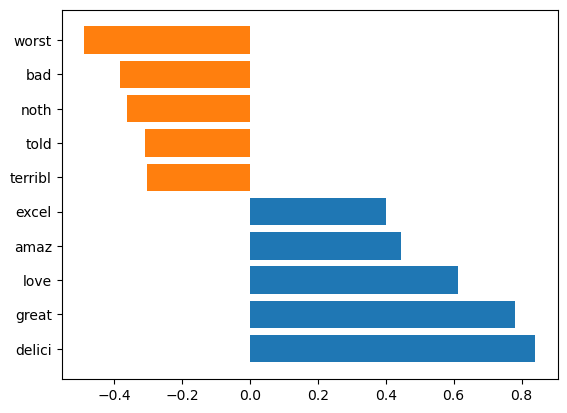

In [58]:
## visualize with bar chart
import matplotlib.pyplot as plt

top = las_coef.sort_values(by = 'coef', ascending = False).iloc[:5]
bot = las_coef.sort_values(by = 'coef', ascending = False).iloc[-5:]

plt.barh(top.feature_name, top.coef)
plt.barh(bot.feature_name, bot.coef)

## to see what matters msot in negative direction and waht matters most in positive direction

# 3. Compare performance across hyperparameters for logistic regression

Would our logit model make more accurate predictions if we fed it different hyperpameters? Which hyperparameters would be the best? Let's find out.

1. Define a function that:
- takes in a cost parameter (*C*, the inverse of regularization strength)
- trains a logistic regression model with L1 regularization (Lasso) and otherwise has the same parameters as above
- fits the model on the training data
- makes predictions and returns them as a DataFrame

2. Use the function to get predictions for the list of *C* parameters below, then bind them into one DataFrame.

3. Finally, score the precision for each model (each iteration of *C*) and show which model scores the best.

**Hint**: To compute precision score, you can use:
```python
precision_score(
    one_df['y_true'], one_df['y_pred'],
    zero_division = 0) # silences warning
```

In [66]:
# Provided set of hyperparameters on which to train and then compare performance
c_list = np.linspace(4, 0.0001, 5) #numbers you can use to insert into model and see what happens to overall performance

In [68]:
# your function code here

def func(c):
    logit_lasso = LogisticRegression(penalty = "l1",max_iter=100, 
             C = c, solver='liblinear') 
    
    logit_lasso.fit(X_train_man[[col for col in X_train.columns if col not in 
                   non_feat]], y_train_man) 

    y_pred = logit_lasso.predict(X_test_man[[col for col 
                in X_test_man.columns if col not in non_feat]])

    y_predprob = logit_lasso.predict_proba(X_test_man[[col for col 
                in X_test_man.columns if col not in non_feat]])

    y_pred_df = pd.DataFrame({'y_pred_binary': y_pred,
                         'y_pred_continuous': [one_prob[1] 
                                            for one_prob in y_predprob],
                         'y_true': y_test_man})

    y_pred_df.sample(n = 10, random_state = 4484)

    return y_pred_df

    

In [82]:
#Use the function to get predictions for the list of C parameters below, then bind them into one DataFrame.
all_c_df = pd.DataFrame()

for c in c_list:
    df = func(c)
    df["c_val"] = c
    all_c_df = pd.concat([all_c_df, df], ignore_index=True)

In [84]:
all_c_df

,y_pred_binary,y_pred_continuous,y_true,c_val
0,0,0.000766,0,4.0000
1,0,0.045243,0,4.0000
2,1,1.000000,1,4.0000
3,0,0.000006,0,4.0000
4,0,0.430249,0,4.0000
...,...,...,...,...
14995,0,0.500000,0,0.0001
14996,0,0.500000,0,0.0001
14997,0,0.500000,0,0.0001
14998,0,0.500000,0,0.0001


In [96]:
# your code here to evaluate precision of each model
## precision as tp / tp+fp 
error_cond = [(all_c_df['y_true'] == 1) & (all_c_df['y_pred_binary'] == 1),
              (all_c_df['y_true'] == 1) & (all_c_df['y_pred_binary'] == 0),
              (all_c_df['y_true'] == 0) & (all_c_df['y_pred_binary'] == 0)]

error_codeto = ["TP", "FN", "TN"]

all_c_df['error_cat'] = np.select(error_cond, error_codeto, default = "FP")


summary = all_c_df.groupby(["c_val", "error_cat"]).size().unstack(fill_value=0).reset_index()

summary['precision'] = summary['TP'] / (summary['TP'] + summary['FP'])
summary['recall'] = summary['TP'] / (summary['TP'] + summary['FN'])

print(summary[['c_val', 'precision', 'recall']])

error_cat     c_val  precision    recall
0          0.000100        NaN  0.000000
1          1.000075   0.863136  0.882560
2          2.000050   0.861687  0.876231
3          3.000025   0.860385  0.879747
4          4.000000   0.860594  0.876934


# 4. Activity 

- Read the documentation here to initialize a ridge regression (l2 penalty)- you can use the same cost parameter (C) and number of iterations as in the lasso example above: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- Fit the model on X_train_man, y_train_main 
- Generate binary and continuous predictions
- Create a function that takes in a dataframe of binary predictions and true labels and manually calculates the $F_{1}$ score:

$$F_{1} = 2 * \dfrac{precision * recall}{precision + recall} = \dfrac{TP}{TP + 0.5(FP + FN)}$$

- Apply that function to calculate the F1 score for the decision tree and lasso (from above), and ridge regression (from the activity)
- *Challenge exercise*: parametrize the model fitting with a function that takes in a classifier as an argument and returns coefficients or feature importances and certain eval metrics (eg precision, recall, and F1)

In [118]:
logit_ridge = LogisticRegression(penalty = "l2",max_iter=100, 
             C = 1, solver='liblinear')

X_feat_tr = X_train_man[[col for col in X_train_man.columns 
                if col not in non_feat]]
X_feat_te = X_test_man[[col for col in X_test_man.columns 
                if col not in non_feat]]
logit_ridge.fit(X_feat_tr, y_train_man)
## predict
y_hat = logit_ridge.predict(X_feat_te)

LogisticRegression(C=1, solver='liblinear')

In [120]:
def manual_f1_score(df, true_col='y_true', pred_col='y_pred'):
    # Extract arrays for convenience
    y_true = df[true_col].values
    y_pred = df[pred_col].values
    
    TP = ((y_true == 1) & (y_pred == 1)).sum()
    FP = ((y_true == 0) & (y_pred == 1)).sum()
    FN = ((y_true == 1) & (y_pred == 0)).sum()
    
    if TP + FP == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)
    
    if TP + FN == 0:
        recall = 0
    else:
        recall = TP / (TP + FN)
    
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    return f1

In [122]:
## would need these names to match the dfs from earlier on


df_dt = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_dt  # predicted labels from decision tree
})

f1_dt = manual_f1_score(df_dt)

# Similarly for lasso
df_lasso = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_lasso
})

f1_lasso = manual_f1_score(df_lasso)

# For ridge
df_ridge = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_ridge
})

f1_ridge = manual_f1_score(df_ridge)

print(f"Decision Tree F1: {f1_dt:.3f}")
print(f"Lasso F1: {f1_lasso:.3f}")
print(f"Ridge F1: {f1_ridge:.3f}")


NameError: name 'y_pred_dt' is not defined

In [135]:

## from someone else...

ridge_lasso = LogisticRegression(penalty = "l2",max_iter=100,
             C = 0.01, solver='liblinear')

ridge_lasso.fit(X_train_man[[col for col in X_train.columns if col not in
                   non_feat]], y_train_man)

y_pred = ridge_lasso.predict(X_test_man[[col for col
                in X_test_man.columns if col not in non_feat]])

y_predprob = ridge_lasso.predict_proba(X_test_man[[col for col
                in X_test_man.columns if col not in non_feat]])

y_pred_binary = ridge_lasso.predict(X_test_man[[col for col in X_test.columns if col not in non_feat]])

y_pred_binary2 = logit_lasso.predict(X_test_man[[col for col in X_test.columns if col not in non_feat]])

from sklearn.metrics import precision_score, recall_score

def manual_f1(y_pred_binary):
    precision = precision_score(y_test_man, y_pred_binary, zero_division=0)
    recall = recall_score(y_test_man, y_pred_binary, zero_division=0)
    f1_manual = 2 * (precision * recall) / (precision + recall)
    
    return f1_manual

print("F1 Score Logistic:", manual_f1(y_pred_binary))
print("F1 Score Logistic:", manual_f1(y_pred_binary2))




LogisticRegression(C=0.01, solver='liblinear')

F1 Score Logistic: 0.8706866504008364
F1 Score Logistic: 0.7926697808120734
